#  Set Up Kaggle API and Download Dataset

In [ ]:
# Create the .kaggle directory and copy the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Download the cataract dataset from Kaggle
!kaggle datasets download -d jr2ngb/cataractdataset

# Unzip the downloaded dataset
!unzip cataractdataset.zip -d /content/


Dataset URL: https://www.kaggle.com/datasets/jr2ngb/cataractdataset
License(s): unknown
100% 3.33G/3.34G [00:32<00:00, 182MB/s]
100% 3.34G/3.34G [00:32<00:00, 112MB/s]
Archive:  cataractdataset.zip
  inflating: /content/README.md      
  inflating: /content/dataset/1_normal/NL_001.png  
  inflating: /content/dataset/1_normal/NL_002.png  
  inflating: /content/dataset/1_normal/NL_003.png  
  inflating: /content/dataset/1_normal/NL_004.png  
  inflating: /content/dataset/1_normal/NL_005.png  
  inflating: /content/dataset/1_normal/NL_006.png  
  inflating: /content/dataset/1_normal/NL_007.png  
  inflating: /content/dataset/1_normal/NL_008.png  
  inflating: /content/dataset/1_normal/NL_009.png  
  inflating: /content/dataset/1_normal/NL_010.png  
  inflating: /content/dataset/1_normal/NL_011.png  
  inflating: /content/dataset/1_normal/NL_012.png  
  inflating: /content/dataset/1_normal/NL_013.png  
  inflating: /content/dataset/1_normal/NL_014.png  
  inflating: /content/dataset/1_norm

 # Remove Unnecessary Directories

In [ ]:
#to remove unnecessary datasets
# Define the path to the folder containing the classes
path = '/content/repository/yiweichen04-retina_dataset-914b0f4/dataset'

# List all directories and store them in a Python list
dirs = !ls -d $path/*/

# Convert the paths to a list of strings
dirs = [d.strip() for d in dirs]

# Print the directories to be removed
print(f"Directories to be removed: {dirs[-2]}, {dirs[-1]}")

# Remove the last two directories
!rm -r {dirs[-2]}
!rm -r {dirs[-1]}

# Verify the removal
!ls $path


Directories to be removed: /content/repository/yiweichen04-retina_dataset-914b0f4/dataset/2_glaucoma/, /content/repository/yiweichen04-retina_dataset-914b0f4/dataset/3_retina_disease/
1_normal  2_cataract


# Check Number of Images

In [ ]:
import os
import shutil
dataset_path = '/content/repository/yiweichen04-retina_dataset-914b0f4/dataset'
for dirpath, dirname, filename in os.walk(dataset_path):
    print(f"Directory: {dirpath}, Subdirectories: {len(dirname)}, Files: {len(filename)}")


Directory: /content/repository/yiweichen04-retina_dataset-914b0f4/dataset, Subdirectories: 2, Files: 0
Directory: /content/repository/yiweichen04-retina_dataset-914b0f4/dataset/1_normal, Subdirectories: 0, Files: 300
Directory: /content/repository/yiweichen04-retina_dataset-914b0f4/dataset/2_cataract, Subdirectories: 0, Files: 100


# Visualize Images

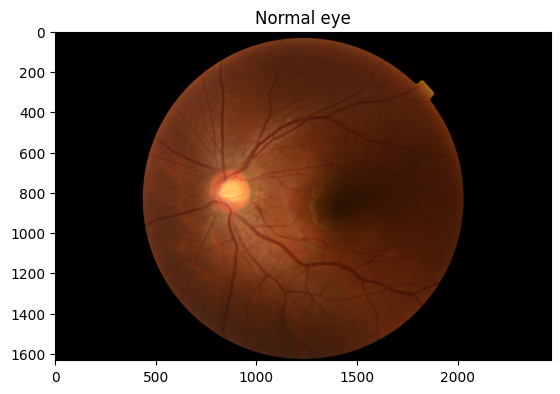

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

def img_show(img_path, title):
    img = cv2.imread(img_path)[:,:,::-1]
    plt.imshow(img)
    plt.title(title)
    plt.show()

img_show('/content/repository/yiweichen04-retina_dataset-914b0f4/dataset/1_normal/NL_001.png', 'Normal eye')


 # Data Augmentation

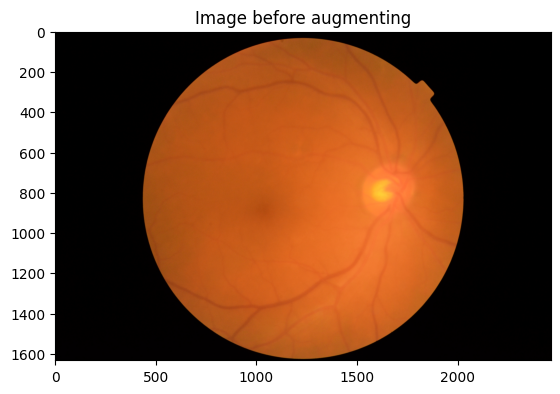

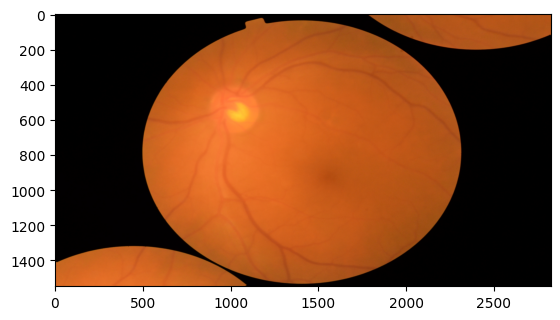

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name="data_augmentation")

# Test the augmentation layer
path = "/content/repository/yiweichen04-retina_dataset-914b0f4/dataset/2_cataract/cataract_075.png"
img_show(path, "Image before augmenting")
img = cv2.imread(path)
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze((augmented_img)/255.)[:, :, ::-1]

plt.figure()
plt.imshow(augmented_img)
plt.show()


# Split Data

In [ ]:
import os
import shutil

# Define paths for train, validation, and test folders
base_path = "/content/repository/yiweichen04-retina_dataset-914b0f4"
original_folder = os.path.join(base_path, "dataset")
train_folder = os.path.join(base_path, "train")
validation_folder = os.path.join(base_path, "validation")
test_folder = os.path.join(base_path, "test")

# Create directories
for folder in [train_folder, validation_folder, test_folder]:
    os.makedirs(os.path.join(folder, "normal"), exist_ok=True)
    os.makedirs(os.path.join(folder, "cataract"), exist_ok=True)

def copy_files(start, stop, src_folder, dst_folder, prefix):
    for i in range(start, stop+1):
        filename = f"{prefix}_{i:03}.png"
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, filename)
        shutil.copy(src_path, dst_path)

# Training set (240 normal, 80 cataract)
copy_files(1, 240, os.path.join(original_folder, "1_normal"), os.path.join(train_folder, "normal"), "NL")
copy_files(1, 80, os.path.join(original_folder, "2_cataract"), os.path.join(train_folder, "cataract"), "cataract")

# Validation set (30 normal, 10 cataract)
copy_files(241, 270, os.path.join(original_folder, "1_normal"), os.path.join(validation_folder, "normal"), "NL")
copy_files(81, 90, os.path.join(original_folder, "2_cataract"), os.path.join(validation_folder, "cataract"), "cataract")

# Test set (30 normal, 10 cataract)
copy_files(271, 300, os.path.join(original_folder, "1_normal"), os.path.join(test_folder, "normal"), "NL")
copy_files(91, 100, os.path.join(original_folder, "2_cataract"), os.path.join(test_folder, "cataract"), "cataract")


# Data Preprocessing

In [ ]:
import tensorflow as tf

train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "validation")

img_size = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    image_size=img_size,
    batch_size=32
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='binary',
    image_size=img_size,
    batch_size=32
)

print(train_data.class_names)


Found 320 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
['cataract', 'normal']


# Model Building

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 base model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze VGG16 layers
for layer in vgg.layers:
    layer.trainable = False

# Create your model on top of VGG16
x = Flatten()(vgg.output)
output = Dense(1, activation='sigmoid')(x)
model = Model(vgg.input, output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# Train and Save the Mode

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
train_path = os.path.join(base_path, "train")
validation_path = os.path.join(base_path, "validation")
model_save_path = os.path.join(base_path, "model/vgg16_model.h5")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=16, class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_path, target_size=(224, 224), batch_size=16, class_mode='binary')

##model.fit(train_generator, validation_data=validation_generator, epochs=2)
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

# Print the model save path
print(f"Model saved at: {model_save_path}")

# Save the model
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)


Found 320 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.8656
Epoch 1: val_loss improved from inf to 0.49463, saving model to /content/repository/yiweichen04-retina_dataset-914b0f4/model/vgg16_model.h5
20/20 [==============================] - 33s 2s/step - loss: 0.2634 - accuracy: 0.8656 - val_loss: 0.4946 - val_accuracy: 0.8750
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.8969
Epoch 2: val_loss improved from 0.49463 to 0.46239, saving model to /content/repository/yiweichen04-retina_dataset-914b0f4/model/vgg16_model.h5
20/20 [==============================] - 30s 1s/step - loss: 0.2640 - accuracy: 0.8969 - val_loss: 0.4624 - val_accuracy: 0.8500
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.8969
Epoch 3: val_loss improved from 0.46239 to 0.44452, saving model to /content/repository/yiweich

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the model
model_path = os.path.join(base_path, "model/vgg16_model.h5")
model = load_model(model_path)

# Predict function
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    prediction = model.predict(img_data)
    index = ['normal', 'cataract']
    result = index[int(prediction[0] > 0.5)]
    return result

# Test the prediction function
test_img_path = '/content/repository/yiweichen04-retina_dataset-914b0f4/test/cataract/cataract_091.png'
result = predict_image(test_img_path)
print(f"Prediction for the test image: {result}")


1/1 [==============================] - 1s 1s/step
Prediction for the test image: cataract


<ipython-input-14-f581e9af1b65>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = index[int(prediction[0] > 0.5)]


# Load the Model and Predict , confusion matrix , classification report

Found 40 images belonging to 2 classes.


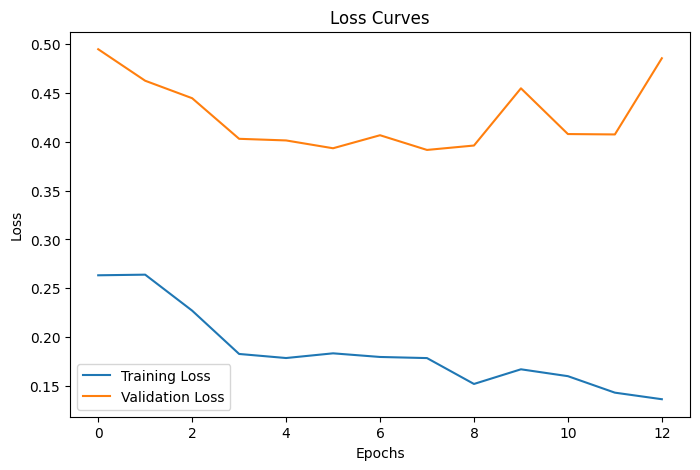

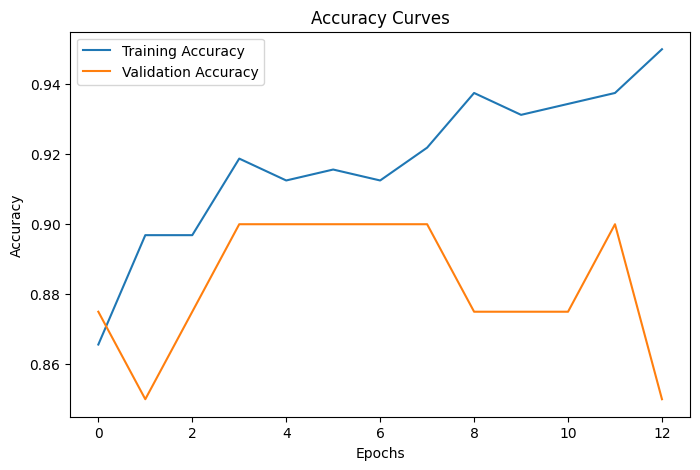

3/3 [==============================] - 4s 937ms/step - loss: 0.1651 - accuracy: 0.9000
Test Loss: 0.16508327424526215
Test Accuracy: 0.8999999761581421
3/3 [==============================] - 3s 917ms/step
Classification Report
              precision    recall  f1-score   support

      Normal       0.25      1.00      0.40        10
    Cataract       0.00      0.00      0.00        30

    accuracy                           0.25        40
   macro avg       0.12      0.50      0.20        40
weighted avg       0.06      0.25      0.10        40

Confusion Matrix:
[[10  0]
 [30  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_path = os.path.join(base_path, "test")
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Plotting loss and accuracy curves
def plot_loss_curves(history):
    # Loss Curves
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy Curves
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss_curves(history)

# Model evaluation on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report and confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Adjusting predictions if they are not binary
if len(y_pred.shape) > 1:
    y_pred = y_pred[:, 0]

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['Normal', 'Cataract']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
'''plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cataract'], yticklabels=['Normal', 'Cataract'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''
print('Confusion Matrix:')
print(cm)